# [2D] Wilson-Cowan model

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

In [2]:
bp.math.enable_x64()

In [3]:
class WilsonCowanModel(bp.dyn.DynamicalSystem):
  def __init__(self, num, method='exp_auto'):
    super(WilsonCowanModel, self).__init__()

    # Connection weights
    self.wEE = 12
    self.wEI = 4
    self.wIE = 13
    self.wII = 11

    # Refractory parameter
    self.r = 1

    # Excitatory parameters
    self.E_tau = 1  # Timescale of excitatory population
    self.E_a = 1.2  # Gain of excitatory population
    self.E_theta = 2.8  # Threshold of excitatory population

    # Inhibitory parameters
    self.I_tau = 1  # Timescale of inhibitory population
    self.I_a = 1  # Gain of inhibitory population
    self.I_theta = 4  # Threshold of inhibitory population

    # variables
    self.i = bm.Variable(bm.ones(num))
    self.e = bm.Variable(bm.ones(num))
    self.Iext = bm.Variable(bm.zeros(num))

    # functions
    def F(x, a, theta):
      return 1 / (1 + bm.exp(-a * (x - theta))) - 1 / (1 + bm.exp(a * theta))

    def de(e, t, i, Iext=0.):
      x = self.wEE * e - self.wEI * i + Iext
      return (-e + (1 - self.r * e) * F(x, self.E_a, self.E_theta)) / self.E_tau

    def di(i, t, e):
      x = self.wIE * e - self.wII * i
      return (-i + (1 - self.r * i) * F(x, self.I_a, self.I_theta)) / self.I_tau

    self.int_e = bp.odeint(de, method=method)
    self.int_i = bp.odeint(di, method=method)

  def update(self, _t, _dt):
    self.e.value = self.int_e(self.e, _t, self.i, self.Iext, _dt)
    self.i.value = self.int_i(self.i, _t, self.e, _dt)
    self.Iext[:] = 0.

## Simulation

In [4]:
model = WilsonCowanModel(2)
model.e[:] = [-0.1, 0.4]
model.i[:] = [0.5, 0.6]

In [5]:
# simulation
runner = bp.dyn.DSRunner(model, monitors=['e', 'i'])
runner.run(100)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.21312761306762695

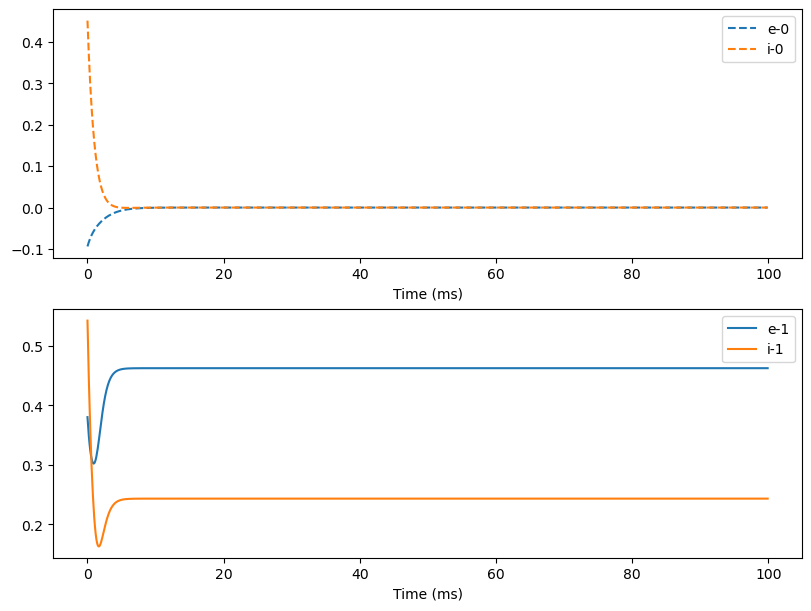

In [6]:
fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon.e, plot_ids=[0], legend='e', linestyle='--')
bp.visualize.line_plot(runner.mon.ts, runner.mon.i, plot_ids=[0], legend='i', linestyle='--')
fig.add_subplot(gs[1, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon.e, plot_ids=[1], legend='e')
bp.visualize.line_plot(runner.mon.ts, runner.mon.i, plot_ids=[1], legend='i', show=True)

## Phase Plane Analysis

I am creating the vector field ...
I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 1966 candidates
I am trying to filter out duplicate fixed points ...
	Found 3 fixed points.
	#1 e=-1.4079366423197298e-07, i=-1.4270381114975852e-06 is a stable node.
	#2 e=0.1780358129856733, i=0.06279970624572741 is a saddle node.
	#3 e=0.46246487195089325, i=0.24336408798332215 is a stable node.
I am plotting the trajectory ...


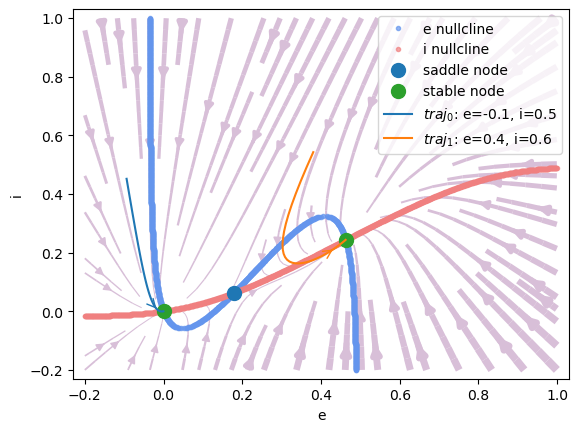

In [7]:
# phase plane analysis
pp = bp.analysis.PhasePlane2D(
  model,
  target_vars={'e': [-0.2, 1.], 'i': [-0.2, 1.]},
  resolutions=0.001,
)
pp.plot_vector_field()
pp.plot_nullcline(coords={'i': 'i-e'})
pp.plot_fixed_point()
pp.plot_trajectory(initials={'i': [0.5, 0.6], 'e': [-0.1, 0.4]},
                   duration=10, dt=0.1)
pp.show_figure()